# Object Detection
## Finding the Pentagon Figure on the page
### Using Python

Creating and Training a model to find the Pentagon figure on the page of the MMSE Document. This goes through a bit of the code. The feature and model creation only need to be ran once. Near the bottom there is a classifier testing code run through.


> Uses methods and modules with the SKlearn and SKImage libraries in python 
>
> --- [scikit-learn 0.19.1. (2017, October). Simple and efficient tools for data mining and data analysis](http://scikit-learn.org/stable/index.html)

In [2]:
# imports
# Import the functions to calculate feature descriptors
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from sklearn.externals import joblib
import cv2
# To read file names
import glob
import os
import numpy as np

# Import the required sklearn modules for models
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd

Must create a correct file structure to save the features for training method

In [3]:
# file structure for feature ies
path = r'training_mmse_pentagons' #change to the base dir for files
pos_im_path = os.path.join(path, 'pos_pent')
neg_im_path = os.path.join(path, 'neg_pent')
pos_feat_ph = os.path.join(path, "pos_feat_ph")
neg_feat_ph = os.path.join(path, "neg_feat_ph")

In using the HOG detection paramaters must be set


Parameters:	
image : (M, N[, C]) ndarray
    Input image.

orientations : int, optional
    Number of orientation bins.

pixels_per_cell : 2-tuple (int, int), optional
    Size (in pixels) of a cell.

cells_per_block : 2-tuple (int, int), optional
    Number of cells in each block.

block_norm : str {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}, optional
    Block normalization method:

In [4]:
#parameters for HOG
#reference: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (3, 3)
des_type = "HOG"

Next create the directory to save the features in

In [5]:
 # If feature directories don't exist, create them
if not os.path.isdir(pos_feat_ph):
    os.makedirs(pos_feat_ph)

# If feature directories don't exist, create them
if not os.path.isdir(neg_feat_ph):
    os.makedirs(neg_feat_ph)

Positive image feature input for the MMSE pentagon example. These are the images for classification, and they can be filled with different images.

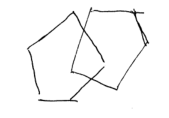

In [6]:
from IPython.display import Image
Image(filename=r'training_mmse_pentagons\pos_pent\pos_2.png') 

Negative image feature input for MMSE example

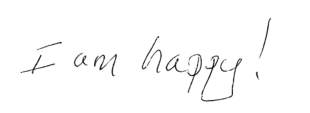

In [7]:
from IPython.display import Image
Image(filename=r'training_mmse_pentagons\neg_pent\neg_3.png') 

For each image path in the positive directory we first read it into the im variable and convert it to graysale
Then it is resized to 128x128 image
Finally create the HOG descriptor for the image. A 1D (flattened) array is returned.

Only needs to be run once to create the features

In [8]:
#may take a couple minutes to run

print("Calculating the descriptors for the positive samples and saving them")
file_count = 0
for im_path in glob.glob(os.path.join(pos_im_path, "*")):
    
    im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE) #Reads image in and convers to grayscale
    im = cv2.resize(im, (128,128))
    if des_type == "HOG":
        fd, _ = hog(im, orientations, pixels_per_cell, cells_per_block, visualise = True, transform_sqrt=True)
        
    fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
    fd_path = os.path.join(pos_feat_ph, fd_name)
    joblib.dump(fd, fd_path) #dumps feature detection in the save path
    file_count += 1
print("Processed {} images for positive features".format(file_count))
print("Positive features saved in {}".format(pos_feat_ph))

Calculating the descriptors for the positive samples and saving them


c:\users\kinectprocessing\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Processed 1057 images for positive features
Positive features saved in training_mmse_pentagons\pos_feat_ph


In [9]:
#may take a couple minutes to run

print("Calculating the descriptors for the negative samples and saving them")
file_count = 0
for im_path in glob.glob(os.path.join(neg_im_path, "*")):
    im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (128,128))
    if des_type == "HOG":
        fd, _ = hog(im,  orientations, pixels_per_cell, cells_per_block, visualise = True, transform_sqrt=True)
    fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
    fd_path = os.path.join(neg_feat_ph, fd_name)
    joblib.dump(fd, fd_path)
    file_count += 1
print("Processed {} images for negative features".format(file_count))
print("Negative features saved in {}".format(neg_feat_ph))

Calculating the descriptors for the negative samples and saving them


c:\users\kinectprocessing\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Processed 1007 images for negative features
Negative features saved in training_mmse_pentagons\neg_feat_ph


In [10]:
print("Completed calculating features from training images")

Completed calculating features from training images


# Train Classifier
## Training with linear SVM

This trains the classifier, only needs to run once in order to create the model.

In [11]:
path = r'training_mmse_pentagons' # change to dir of testing path
pos_im_path = os.path.join(path, 'pos_pent')
neg_im_path = os.path.join(path, 'neg_pent')

pos_feat_ph = os.path.join(path, "pos_feat_ph")
neg_feat_ph = os.path.join(path, "neg_feat_ph")

model_path =  os.path.join(path, "models", "svm.model") # where to save the model

pos_feat_path =  pos_feat_ph
neg_feat_path =  neg_feat_ph

# Classifiers supported
clf_type = "LIN_SVM"

fds = []
labels = []
# Load the positive features
for feat_path in glob.glob(os.path.join(pos_feat_path,"*.feat")):
    fd = joblib.load(feat_path)
    fds.append(fd)
    labels.append(1)

# Load the negative features
for feat_path in glob.glob(os.path.join(neg_feat_path,"*.feat")):
    fd = joblib.load(feat_path)
    fds.append(fd)
    labels.append(0)

if clf_type is "LIN_SVM":
    clf = LinearSVC()
    print("Training a Linear SVM Classifier")
    print(len(fds), len(labels))
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    if not os.path.isdir(os.path.split(model_path)[0]):
        os.makedirs(os.path.split(model_path)[0])
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))




Training a Linear SVM Classifier
2064 2064
Classifier saved to training_mmse_pentagons\models\svm.model


# Testing Classifiers

Can use this to test different classifier models with the features. 

In [ ]:
def test_classifiers(data, lables, clf):
    """
    create training objects
    """
    data = np.array(data)
    print("Total object(n) = " + str(len(data)))
    is_train = np.random.uniform(0, 1, len(data)) <= 0.8 # split randomly: train with 80%,other 20% for testing classifier
    y = np.where(np.array(labels)== 1, 1, 0)

    #set training and test data
    train_x, train_y = data[is_train], y[is_train]
    test_x, test_y = data[is_train==False], y[is_train==False]


    pca = PCA(n_components=5, svd_solver='randomized')
    print("Trainng set n = " + str(len(data[is_train])))
    print("Testing set n = " + str(len(data[is_train==False])))
    train_x = pca.fit_transform(train_x)
    test_x = pca.transform(test_x)
    clf.fit(train_x, train_y)
    df = pd.crosstab(test_y, clf.predict(test_x), rownames=["Actual"], colnames=["Predicted"])
    score = clf.score(test_x, test_y)
    print(df)
    print("Score: " + str(score))
    print("")

In [ ]:
path = r'training_mmse_pentagons'
pos_im_path = os.path.join(path, 'pos_pent')
neg_im_path = os.path.join(path, 'neg_pent')

pos_feat_ph = os.path.join(path, "pos_feat_ph")
neg_feat_ph = os.path.join(path, "neg_feat_ph")

def make_model(model_type):
    model_name = model_type + ".model"
    model_path =  os.path.join(path, "models", model_name)
    return model_path

pos_feat_path =  pos_feat_ph
neg_feat_path =  neg_feat_ph

# Classifiers supported


fds = []
labels = []
# Load the positive features
for feat_path in glob.glob(os.path.join(pos_feat_path,"*.feat")):
    fd = joblib.load(feat_path)
    fds.append(fd)
    labels.append(1)

# Load the negative features
for feat_path in glob.glob(os.path.join(neg_feat_path,"*.feat")):
    fd = joblib.load(feat_path)
    fds.append(fd)
    labels.append(0)

    
## TO actually create the models, remove the comments on joblib.dump    
clf_type = "LIN_SVM"
if clf_type is "LIN_SVM":
    clf = LinearSVC()
    print("Testing Linear SVM Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)
    

clf_type = "KNN"
if clf_type is "KNN":
    clf = KNeighborsClassifier()
    print("Testing KNN Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)

clf_type = "RandomForest"
if clf_type is "RandomForest":
    clf = RandomForestClassifier(n_jobs=2)
    print("Testing Random Forest Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)

clf_type = "DecisionTreeCLassifier"
if clf_type is "DecisionTreeCLassifier":
    clf = DecisionTreeClassifier(random_state=0)
    print("Testing Decision Tree Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)

    
clf_type = "GaussianProcessClassifier"
if clf_type is "GaussianProcessClassifier":
    #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
    clf = GaussianProcessClassifier()
    print("Testing Gaussian Process Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)


clf_type = "MLPClassifier"
if clf_type is "MLPClassifier":
    #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
    clf = MLPClassifier(alpha=1)
    print("Testing MLPClassifier Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)


clf_type = "SVC"
if clf_type is "SVC":
    #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
    clf = SVC()
    print("Testing SVC Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)


clf_type = "AdaBoost"
if clf_type is "AdaBoost":
    #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
    clf = AdaBoostClassifier()
    print("Testing AdaBoost Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)


clf_type = "GaussianNB"
if clf_type is "GaussianNB":
    #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
    clf = GaussianNB()
    print("Testing GaussianNB Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)


clf_type = "QuadraticDiscriminantAnalysis"
if clf_type is "QuadraticDiscriminantAnalysis":
    #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
    clf = QuadraticDiscriminantAnalysis()
    print("Testing QuadraticDiscriminantAnalysis Classifier")
    clf.fit(fds, labels)
    # If feature directories don't exist, create them
    model_path = make_model(clf_type)
    #joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))
    
    test_classifiers(fds, labels, clf)



Testing Linear SVM Classifier
Classifier saved to training_mmse_pentagons\models\LIN_SVM.model
Total object(n) = 2064
Trainng set n = 1654
Testing set n = 410
Predicted    0    1
Actual             
0          214    4
1            9  183
Score: 0.9682926829268292

Testing KNN Classifier
Classifier saved to training_mmse_pentagons\models\KNN.model
Total object(n) = 2064
Trainng set n = 1673
Testing set n = 391
Predicted    0    1
Actual             
0          194    1
1           11  185
Score: 0.969309462915601

Testing Random Forest Classifier
Classifier saved to training_mmse_pentagons\models\RandomForest.model
Total object(n) = 2064
Trainng set n = 1670
Testing set n = 394
Predicted    0    1
Actual             
0          194    4
1            9  187
Score: 0.9670050761421319

Testing Decision Tree Classifier
Classifier saved to training_mmse_pentagons\models\DecisionTreeCLassifier.model
Total object(n) = 2064
Trainng set n = 1622
Testing set n = 442
Predicted    0    1
Actual   

## EXAMPLE WITH SAMPLE MMSE PAGES


In [ ]:
def detection(img, model_path):
    '''
    The detections methond using the HOG SVM algorithm
    '''
    clf = joblib.load(model_path) #prediciton method using SVM
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    im_reshape = cv2.resize(opening, (128,128)) # reduces noise on image
    fd, _ = hog(im_reshape,9, (8,8), (3,3), visualise = True, transform_sqrt=True)           
    pred = clf.predict(fd)
    #print(pred)
    #print(clf.decision_function(fd))
    #if pred == 1:
    #    return clf.decision_function(fd)
    #else:
    #    return 0
    return pred
    

## Walk the path and pull a random MMSE scanned page
Print filename and show image

In [ ]:
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib
import cv2, os, time, math, itertools, random, xlwt
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
testing_path = r'sample_pents'
model_path =  os.path.join(path, "models", "svm.model")
file = random.choice([x for x in os.listdir(testing_path) if os.path.isfile(os.path.join(testing_path, x))])
print(file)
test_file = os.path.join(testing_path, file)
im = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(im,cmap='gray')
plt.show()

## Find the all the contours in the image using the cv2.find contours method and bound
http://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a

In [ ]:
clone = im.copy() #clone image
color_im = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 
#preprocessing of image applying gaussianblur and thresholding OTSU
blur = cv2.GaussianBlur(clone,(5,5),0) 
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#preprocessing of image applying canny edge detection and dialtion to get all contours
edges = cv2.Canny(th3,0,255,apertureSize = 5) # Canny image 
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)) # create the kernle
edges = cv2.dilate(edges, kernel, iterations=5)

im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # find each contour
cv2.drawContours(color_im, contours, -1, (255,255,0), 3) #draw all contours

img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 

for cnt in contours:
        # get the perimeter circularity of the contours
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull,True)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)   
#img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
detection_threshold = 1.0 # change this to change accepted detection High is above 1.5... Low is 0.5


models = r'training_mmse_pentagons\models'
model_list = os.listdir(models)
for model in model_list:
    model_path = os.path.join(models, model)
    print(model)
    
    img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 
    found_dets = []

    for cnt in contours:
        # get the perimeter circularity of the contours
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull,True)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            if (h*w) > 200: # minimum area of the contour bounding box
                feature = clone[y:y + h, x:x + w]
                try:
                    cd = detection(feature, model_path)
                    print('detection at', x,y, 'detection score:', cd)
                    if (cd==1): #threshold for acceptance for HOG
                        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
                        found_dets.append((x, y, cd, w, h))
                except:
                    pass
    #img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
